In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display
from scipy.interpolate import make_interp_spline

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [108]:
data = pd.read_csv("data_AQIweather.csv")
date_time = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
data = data.drop(columns = ['time','date','Year','Day'])
data.head()


,PM2.5_obj,NOx_obj,SO2_obj,Hour,Month,windspeedKmph,winddirDegree,tempC,humidity
0,118.4,34.2,1.700000,0,1,14,10,7,35
1,117.4,33.1,1.400000,1,1,14,17,7,34
2,101.0,31.5,1.000000,2,1,14,25,7,34
3,73.2,30.0,0.833333,3,1,14,32,6,34
4,53.0,30.0,0.666667,4,1,15,24,6,34


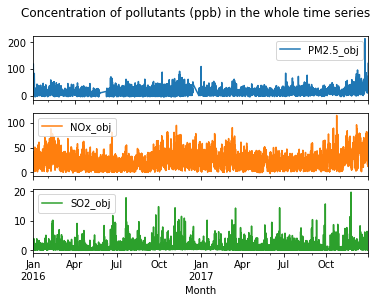

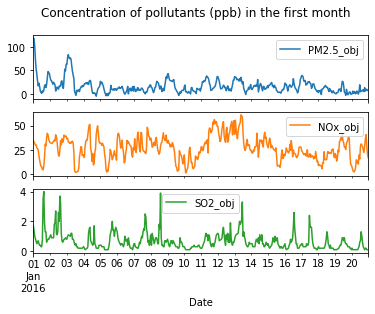

In [109]:
plot_cols = ['PM2.5_obj', 'NOx_obj', 'SO2_obj']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, xlabel = "Month", title = "Concentration of pollutants (ppb) in the whole time series")

plot_features = data[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, xlabel = "Date", title = "Concentration of pollutants (ppb) in the first month")


In [110]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5_obj,17544.0,14.732991,11.668922,-4.9,7.60,12.6,19.20,214.3
NOx_obj,17544.0,24.596224,16.324736,-2.5,11.10,22.8,34.80,115.5
SO2_obj,17544.0,0.871170,1.115041,0.0,0.30,0.5,1.00,19.7
Hour,17544.0,11.500000,6.922384,0.0,5.75,11.5,17.25,23.0
Month,17544.0,6.519836,3.449649,1.0,4.00,7.0,10.00,12.0
windspeedKmph,17544.0,7.687415,4.690475,0.0,4.00,7.0,10.00,42.0
winddirDegree,17544.0,188.466655,76.870087,0.0,144.00,208.0,239.00,360.0
tempC,17544.0,19.928694,6.017436,5.0,15.00,20.0,24.00,41.0
humidity,17544.0,57.029925,21.308192,9.0,41.00,58.0,74.00,98.0


In [111]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]

In [112]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

def eval(A):
    return A/2

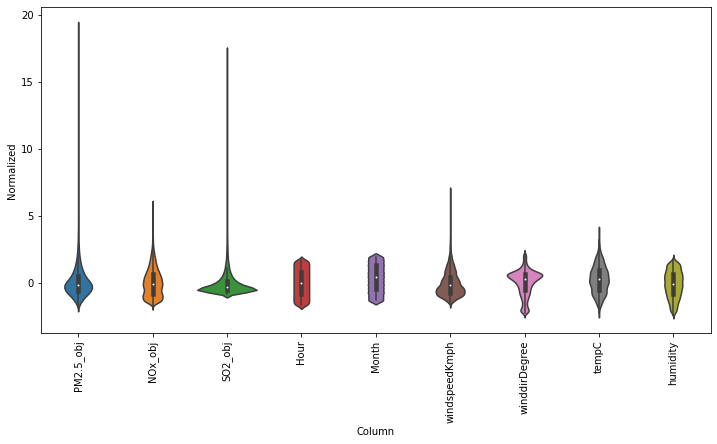

In [113]:
data_std = (data - train_mean) / train_std
data_std = data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)
plt.savefig("P2_Normalized_Data.png",dpi=800)

In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_data=train_data, val_data=val_data, test_data=test_data,
        label_columns=None):
        # Store the raw data.
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_data.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
             labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                    axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, model=None, plot_col="PM2.5_obj", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                  label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                  label_col_index = plot_col_index

            if label_col_index is None:
                  continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                  data=data,
                  targets=None,
                  sequence_length=self.total_window_size,
                  sequence_stride=1,
                  shuffle=True,
                  batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

In [10]:
@property
def train(self):
    return self.make_dataset(self.train_data)

@property
def val(self):
    return self.make_dataset(self.val_data)

@property
def test(self):
    return self.make_dataset(self.test_data)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [12]:
wide_window1 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["PM2.5_obj"])

wide_window2 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["SO2_obj"])

wide_window3 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["NOx_obj"])

In [13]:
lstm_model1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
lstm_model3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [49]:
lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 16)            160       
                                                                 
 lstm (LSTM)                 (None, 24, 32)            6272      
                                                                 
 dense_1 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [14]:
history1 = compile_and_fit(lstm_model1, wide_window1)

IPython.display.clear_output()
val_performance1 = lstm_model1.evaluate(wide_window1.val)
performance1 = lstm_model1.evaluate(wide_window1.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.4836 - mean_absolute_error: 0.5121


In [15]:
history2 = compile_and_fit(lstm_model2, wide_window2)

IPython.display.clear_output()
val_performance2 = lstm_model2.evaluate(wide_window2.val)
performance2 = lstm_model2.evaluate(wide_window2.test, verbose=0)

109/109 [==============================] - 0s 4ms/step - loss: 0.4772 - mean_absolute_error: 0.3685


In [16]:
history3 = compile_and_fit(lstm_model3, wide_window3)

IPython.display.clear_output()
val_performance3 = lstm_model3.evaluate(wide_window3.val)
performance3 = lstm_model3.evaluate(wide_window3.test, verbose=0)

109/109 [==============================] - 0s 4ms/step - loss: 0.1347 - mean_absolute_error: 0.2555


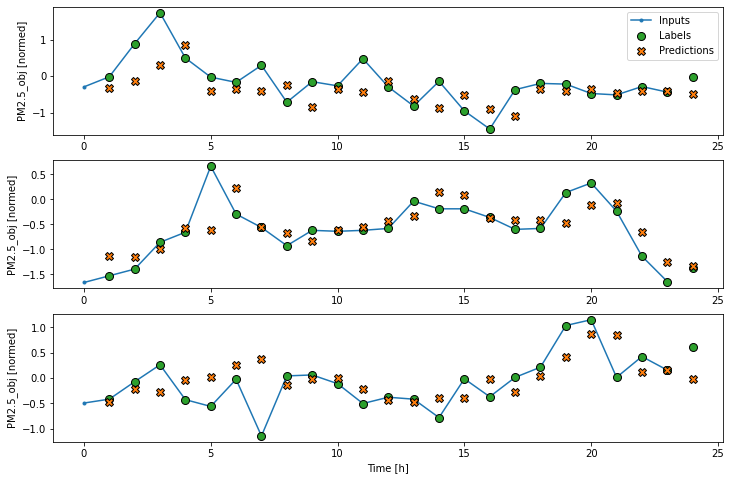

In [99]:
wide_window1.plot(lstm_model1,"PM2.5_obj")
plt.savefig("P2_PM_LSTM.png",dpi=800)

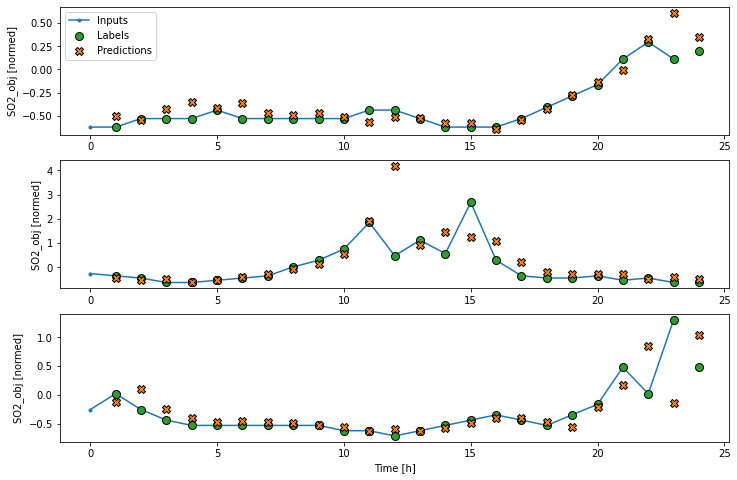

In [100]:
wide_window2.plot(lstm_model2,"SO2_obj")
plt.savefig("P2_SO2_LSTM.png",dpi=800)

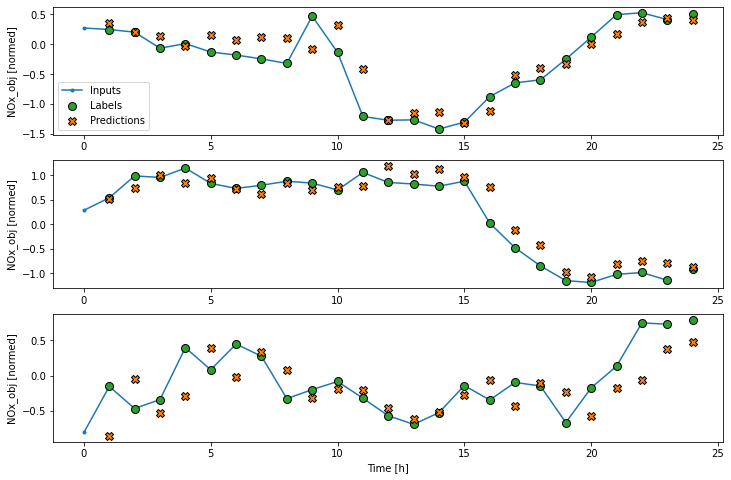

In [101]:
wide_window3.plot(lstm_model3,"NOx_obj")
plt.savefig("P2_NOx_LSTM.png",dpi=800)

In [20]:
GRU_model1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, GRU_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
GRU_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, GRU_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
GRU_model3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, GRU_units]
    tf.keras.layers.Dense(units=16, activation = 'relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [21]:
history4 = compile_and_fit(GRU_model1, wide_window1)

IPython.display.clear_output()
val_performance4 = GRU_model1.evaluate(wide_window1.val)
performance4 = GRU_model1.evaluate(wide_window1.test, verbose=0)

109/109 [==============================] - 0s 4ms/step - loss: 0.4742 - mean_absolute_error: 0.5117


In [22]:
history5 = compile_and_fit(GRU_model2, wide_window2)

IPython.display.clear_output()
val_performance5 = GRU_model2.evaluate(wide_window2.val)
performance5 = GRU_model2.evaluate(wide_window2.test, verbose=0)

109/109 [==============================] - 0s 4ms/step - loss: 0.4636 - mean_absolute_error: 0.3646


In [23]:
history6 = compile_and_fit(GRU_model3, wide_window3)

IPython.display.clear_output()
val_performance6 = GRU_model3.evaluate(wide_window3.val)
performance6 = GRU_model3.evaluate(wide_window3.test, verbose=0)

109/109 [==============================] - 0s 4ms/step - loss: 0.1294 - mean_absolute_error: 0.2518


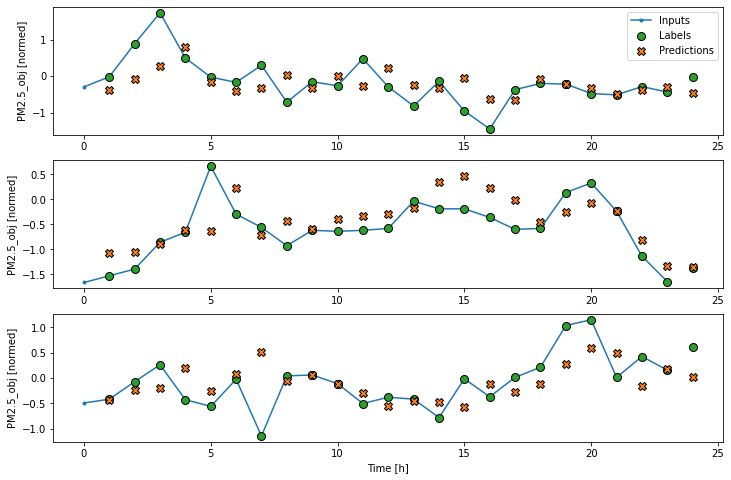

In [102]:
wide_window1.plot(GRU_model1,"PM2.5_obj")
plt.savefig("P2_PM_GRU.png",dpi=800)

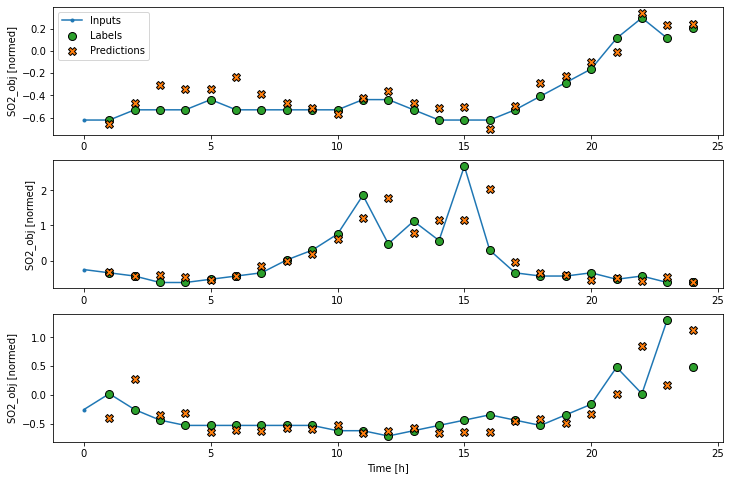

In [103]:
wide_window2.plot(GRU_model2,"SO2_obj")
plt.savefig("P2_SO2_GRU.png",dpi=800)

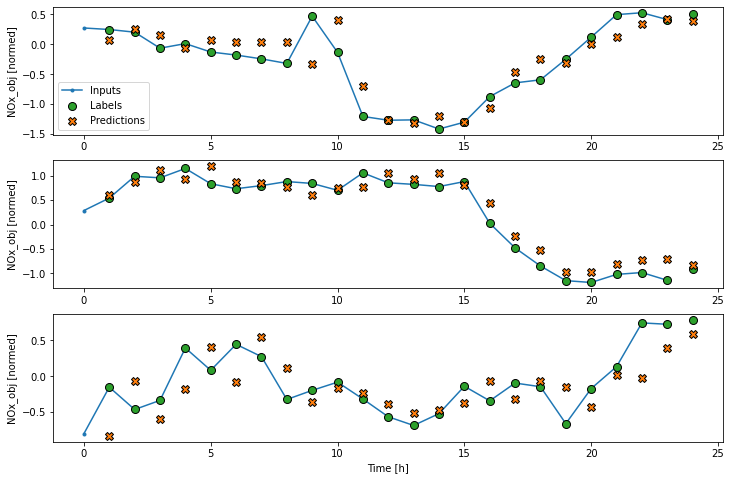

In [104]:
wide_window3.plot(GRU_model3,"NOx_obj")
plt.savefig("P2_NOx_GRU.png",dpi=800)

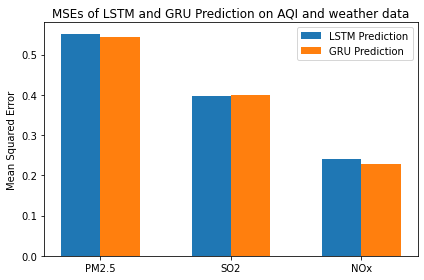

In [53]:
labels=["PM2.5","SO2","NOx"]
lstm_perfrom = [eval(performance1[0]),eval(performance2[0]),performance3[0]]
gru_perfrom = [eval(performance4[0]),eval(performance5[0]),performance6[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lstm_perfrom, width, label='LSTM Prediction')
rects2 = ax.bar(x + width/2, gru_perfrom, width, label='GRU Prediction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Squared Error')
ax.set_title('MSEs of LSTM and GRU Prediction on AQI and weather data')
plt.xticks(x,labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig("MSEs of LSTM and GRU Prediction on AQI and weather data.png",dpi=800)

plt.show()

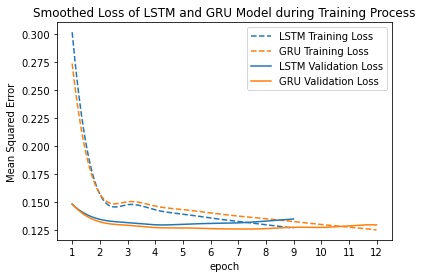

In [98]:
x1 = np.arange(1,10)
x2 = np.arange(1,13)
x01 = np.arange(1,9+0.01,0.01)
x02 = np.arange(1,12+0.01,0.01)
spl1 = make_interp_spline(x1,history3.history['loss'])
spl2 = make_interp_spline(x2,history6.history['loss'])
spl3 = make_interp_spline(x1,history3.history['val_loss'])
spl4 = make_interp_spline(x2,history6.history['val_loss'])
plt.plot(x01,spl1(x01),ls = '--',c='#1f77b4',label = "LSTM Training Loss")
plt.plot(x02,spl2(x02),ls = '--',c='#ff7f0e',label = "GRU Training Loss")
plt.plot(x01,spl3(x01),c='#1f77b4',label = "LSTM Validation Loss")
plt.plot(x02,spl4(x02),c='#ff7f0e',label = "GRU Validation Loss")
plt.xticks(x2)
plt.legend()
plt.title("Smoothed Loss of LSTM and GRU Model during Training Process")
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.savefig("Smoothed Loss of LSTM and GRU Model during Training Process.png",dpi = 800)
plt.show()
